**PGM Assignment 2**

**Group 19**

|Name|BITS ID|
|--|--|
|Vinayak Nayak|2021fc04135|
|Shreysi Kalra|2021fc04586|
|Karan Khajuria|2021fc04951|

We have modelled the problem as a classification problem considering `Loan Payment Status` as the target variable and all other variables as independent ones. We have used the following techniques in modelling

1. Logistic Regression with SGD Classifier from sklearn
2. MultiLayer Perceptron (Deep Learning Model)
3. Probabilistic Deep Learning Model

Due to limitation of compute resources and time, we have made certain modelling assumptions that we have stated as and when we make these modelling decisions. Also the auxillary files, models and code which we used to perform this training could be found [here](https://drive.google.com/drive/folders/1iYEX8HZO33JLYUlDRswRpkAO_75U2E4n?usp=sharing).

**System Configuration for model training**

- For Training Logistc Regression with SGD Classifier & keras MLP DL Model (Local)
    - 12 GB RAM
    - 100 GB Disk Space
    - ~ 2 days of compute
    - 4 GB GPU RAM

- For training Probabilistic Deep Learning Model (Google Colab)
    - 12 GB RAM
    - 128 GB Disk Spacr
    - 16 GB GPU RAM
    - ~ 6 hrs of compute

In [ ]:
# Import standard libraries needed for processing
from collections import defaultdict, Counter
from pathlib import Path
import pickle, re, csv
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

# Import linear algebra libraries
import numpy as np
import pandas as pd
import random

# Import plotting libraries 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Import preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier

# Suppress unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Get column names by reading the first line only
f = open("Multifamily/FNMA_MF_Loan_Performance_Data_202203.csv", "r")
colnames = f.readline().replace("\n", "").split(",")
print(colnames)

['Loan Number', 'Acquisition Date', 'Note Date', 'Maturity Date at Acquisition', 'Loan Acquisition UPB', 'Amortization Type', 'Interest Type', 'Loan Product Type', 'Original UPB', 'Amortization Term', 'Original Interest Rate', 'Lien Position', '"Transaction ID "', 'Issue Date', 'Loan Acquisition LTV', 'Underwritten DSCR', 'Underwritten DSCR Type', 'Original Term', 'Original I/O Term', 'I/O End Date', 'Loan Ever 60+ Days Delinquent', 'Loss Sharing Type', 'Modified Loss Sharing Percentage', 'Number of Properties at Acquisition', 'Property Acquisition Total Unit Count', 'Specific Property Type', 'Year Built', 'Property City', 'Property State', 'Property Zip Code', 'Metropolitan Statistical Area', 'Physical Occupancy %', 'Liquidation/Prepayment Code', 'Liquidation/Prepayment Date', 'Foreclosure Date', 'Credit Event Date', 'Foreclosure Value', 'Lifetime Net Credit Loss Amount', 'Sale Price', 'Default Amount', 'Credit Event Type', 'Reporting Period Date', 'Loan Active Property Count', 'Note 

In [ ]:
# Read all the lines
# Read first one fourth of columns and iteratively read all slices to avoid running out of memory
# Do this iteratively with slices
# slice(0, 15), slice(15, 30), slice(30, 45), slice(45, 60)

lengths = []
d = defaultdict(lambda: [])
slc = slice(0, 15)

with open(
    "Multifamily/FNMA_MF_Loan_Performance_Data_202203.csv", newline="\n"
) as csvfile:
    filereader = csv.reader(csvfile, delimiter=",", quotechar='"')
    for row in filereader:
        feats = row[slc]
        for f, c in zip(feats, colnames[slc]):
            if f != c:
                d[c].append(f)

In [ ]:
# Write the individual columns to a single file for easier preprocessing
for k, v in d.items():
    with open(f"piecewise_columns_files/{k.replace('/', '_')}.txt", "w") as f_out:
        for item in v:
            f_out.writelines(f"{item}\n")
    f_out.close()

In [ ]:
# Free the memory occupied unnecessarily 
import gc
del d; gc.collect()

# Read the individual column files and summarize them

In [ ]:
# from IPython.display import IFrame
# IFrame(src='https://capitalmarkets.fanniemae.com/media/5986', width=700, height=600)

In [ ]:
# If the percentage of missing values in a column is more than 90%, then it is not possible to model using
# this variable; in such a case, imputation might lead to highly unrealistic results
ACCEPTANCE_THRESHOLD_PCT = 80
cols_to_drop = []
recs = []

def summarize_file(filepth):
    with open(filepth, "r") as f:
        coldata = [x.replace("\n", "") for x in f.readlines()]

    # Find out the number of unique values and proportion of missing data
    unique_vals = len(set([x for x in coldata if x != ""]))
    sample = [x.replace("\n", "") for x in list(set(coldata))[:7]]
    sample = [x for x in sample if x != ""]
    actual_data = [x for x in coldata if x != ""]

    # Compute missing data proportion as percentages
    missing_vals = len(coldata) - len(actual_data)
    missing_prop = round(missing_vals / len(coldata) * 100, 3)
    actual_prop = 100 - missing_prop

    # If prop of missing data is more than a particular threshold then drop those columns
    if missing_prop > ACCEPTANCE_THRESHOLD_PCT:
        cols_to_drop.append(filepth.stem)

    # Keep a dataframe of summary_stats
    recs.append([filepth.stem, unique_vals, missing_vals, missing_prop, actual_prop])

    # Print each columns summary
    print(
        f"{filepth.stem:<20} | Unique: {str(unique_vals):<5} | Missing Count: {str(missing_vals):<5} | Missing Proportion: {missing_prop:.3f}% | Available: {actual_prop:.3f}%\nFive examples of data in this column: {sample}\n"
    )

In [ ]:
# Get the names of all the files
files = [ x for x in Path("piecewise_columns_files/").glob("**/*")
          if (x.is_file() and (not ".ipynb" in str(x)))]

# Read all the files
for f in files:
    summarize_file(f)

Loan Acquisition LTV | Unique: 2334  | Missing Count: 193   | Missing Proportion: 0.005% | Available: 99.995%
Five examples of data in this column: ['24.72', '78.7', '14.0', '5.9', '57.15', '14.5']

SDQ Indicator        | Unique: 2     | Missing Count: 0     | Missing Proportion: 0.000% | Available: 100.000%
Five examples of data in this column: ['Y', 'N']

Underwritten DSCR Type | Unique: 4     | Missing Count: 820   | Missing Proportion: 0.020% | Available: 99.980%
Five examples of data in this column: ['Deal UW DSCR NCF', 'UW DSCR NCF', 'Lender UW DSCR', 'UW Actual DSCR']

Property State       | Unique: 54    | Missing Count: 0     | Missing Proportion: 0.000% | Available: 100.000%
Five examples of data in this column: ['NH', 'GA', 'MS', 'PA', 'WI', 'PR', 'AK']

Liquidation_Prepayment Date | Unique: 3205  | Missing Count: 4043609 | Missing Proportion: 99.146% | Available: 0.854%
Five examples of data in this column: ['2005-10-11', '2015-01-30', '2012-07-13', '2019-04-12', '2022-01-2

In [ ]:
# Make a dataframe of records and display the columns which would be dropped based on the threshold criterion above
df = pd.DataFrame( recs, columns=["Filepath", "Unique", "MissingCount", "MissingProp(%)", "ActualProp(%)"])
print(len(cols_to_drop))
print(" | ".join(cols_to_drop))

16
Liquidation_Prepayment Date | Foreclosure Value | Delinquency UPB | MCIRT Deal ID | Credit Event Type | Affordable Housing Type | Modified Loss Sharing Percentage | Credit Event Date | Defeasance Date | Liquidation_Prepayment Code | Foreclosure Date | MCAS Deal ID | Default Amount | Lifetime Net Credit Loss Amount | Sale Price | Most Recent Modification Date


In [ ]:
# Get the files which are needed and which are not needed
all_text_files = [x for x in Path("piecewise_columns_files/").glob("*") if x.is_file()]
val_text_files = [x for x in all_text_files if (not x.stem in cols_to_drop)]
unwanted_text_files = [x for x in all_text_files if x not in val_text_files]
len(all_text_files), len(val_text_files), len(unwanted_text_files)

(60, 44, 16)

In [ ]:
# View all the stats at once in increasing order of missing percentage
df.sort_values(by="MissingProp(%)").reset_index(drop=True)

,Filepath,Unique,MissingCount,MissingProp(%),ActualProp(%)
0,Year Built,179,8,0.000,100.000
1,Original UPB,19577,0,0.000,100.000
2,Property Zip Code,8368,0,0.000,100.000
3,Loan Number,61048,0,0.000,100.000
4,Maturity Date at Acquisition,572,0,0.000,100.000
5,Loan Ever 60+ Days Delinquent,2,0,0.000,100.000
6,UPB - Current,3068727,0,0.000,100.000
7,Property City,3640,0,0.000,100.000
8,Amortization Type,5,8,0.000,100.000
9,Loan Payment Status,4,0,0.000,100.000


In [ ]:
# Look at the dataframe by sorting cardinality and missing propportion of all the columns
df = df[df["MissingProp(%)"] < ACCEPTANCE_THRESHOLD_PCT].reset_index(drop=True)
df.sort_values(by=["Unique", "MissingProp(%)"]).reset_index(drop=True)

,Filepath,Unique,MissingCount,MissingProp(%),ActualProp(%)
0,SDQ Indicator,2,0,0.000,100.000
1,Modification Indicator,2,0,0.000,100.000
2,Loan Ever 60+ Days Delinquent,2,0,0.000,100.000
3,Interest Type,2,0,0.000,100.000
4,Loss Sharing Type,3,167134,4.098,95.902
5,Loan Payment Status,4,0,0.000,100.000
6,Loan Product Type,4,0,0.000,100.000
7,Lien Position,4,96,0.002,99.998
8,Underwritten DSCR Type,4,820,0.020,99.980
9,Amortization Type,5,8,0.000,100.000


In [ ]:
# Some ID columns need to be dropped otherwise we will not be able to make predictions on new data
# i.e. if a new ID is encountered, we will not have a representation for it
more_cols_to_drop = ['"Transaction ID "', "Loan Number"]

In [ ]:
# Define different columns' datatypes here i.e. categorical/date/numerical/ordinal etc.
categorical_columns = [
    "Modification Indicator", "SDQ Indicator", "Interest Type", "Loan Ever 60+ Days Delinquent", "Loss Sharing Type",
    "Loan Payment Status", "Loan Product Type", "Lien Position",    "Underwritten DSCR Type",    "Amortization Type",
    "DUS Prepayment Segments", "Specific Property Type",  "DUS Prepayment Outcomes",  "Property State",  
    "Metropolitan Statistical Area", "Prepayment Provision", "Property City", "Property Zip Code"
]

# Remove target column from cateorical columns
# It will be separately modelled
target_column = "Loan Payment Status"
categorical_columns.remove(target_column)

# Get all the date columns, we can extract the day, month and year from these 
# separately and use it for our modelling purposes
date_columns = df[df.Filepath.apply(lambda x: "date" in x.lower())].Filepath.tolist()

# Whatever's remaining will go into numerical columns
numerical_columns = list(
    set(df.Filepath) - set(date_columns) - set(categorical_columns) - set(more_cols_to_drop)
)

In [ ]:
len(categorical_columns), len(date_columns), len(numerical_columns), len(df)

(17, 8, 17, 44)

Since all the categorical columns have at most 8k as the cardinality, an `int32` label encoding would be very helpful in saving space and representing the columns in a numerical instead of string/char representation.

Also we could do mode imputation here and fill the missing values for each of the columns

In [ ]:
import pickle
from collections import Counter

for f in all_text_files:
    if (f.stem in categorical_columns) or (f.stem == target_column):
        # Read the file contents into a list
        contents = [x.replace("\n", "") for x in open(f, "r").readlines()]

        # Compute the counts
        count_contents = [x for x in contents if x != ""]
        most_common_value = Counter(contents).most_common()[0][0]

        # Fill null values with the most frequently occuring entry
        imputed_contents = []
        for element in contents:
            if element == "":
                imputed_contents.append(most_common_value)
            else:
                imputed_contents.append(element)

        # Assign numeric codes to the categories
        column_code_map = {}
        for idx, lbl in enumerate(sorted(list(set(count_contents)))):
            column_code_map[lbl] = idx

        # Save this information in a pickle/json file for later use
        encoded_column = [column_code_map[x] for x in imputed_contents]
        d = {"data": encoded_column, "decode_key": column_code_map}

        with open(f"required_columns_compressed_representation/{f.stem}.pkl", "wb") as f:
            pickle.dump(d, f)

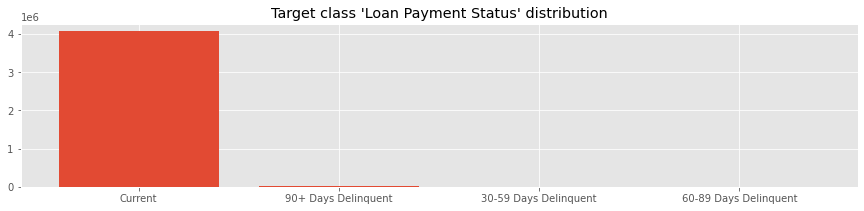

In [ ]:
# Understand the target class distribution
target_data = pickle.load(open("required_columns_compressed_representation/Loan Payment Status.pkl", "rb"))

data, dec_key = target_data["data"], target_data["decode_key"]
rev_dec_key = {v:k for k, v in dec_key.items()}

xs = Counter(data).keys()
xs = [rev_dec_key[x] for x in xs]
ys = Counter(data).values()

plt.figure(figsize = (15, 3))
plt.bar(xs, ys);
plt.title(f"Target class 'Loan Payment Status' distribution");

The given dataset's target class is highly imbalanced with almost no entries in defaulter's segment. Most of the loans are current status only.

In [ ]:
for k, v in Counter(data).items():
    print(f"{rev_dec_key[k]:<25}| {v}")

Current                  | 4060092
90+ Days Delinquent      | 11247
30-59 Days Delinquent    | 4716
60-89 Days Delinquent    | 2380


It will be very challenging for the model to learn from this data distribution due to extreme sparsity of the delinquent class. We could do several things here.

- Combine all delinquent classes into one single class in order to reduce the target diversity and model for loan status as delinquent or not delinquent. Later within delinquent class we can again model for the different sub-classes or types of delinquency.
- Reduce the rows or records of the current class to make the data distribution equitable in nature.
- Oversample the rows of delinquent class so that the model sees delinquent class records as much as or at least a sizable number of times as much as the current class distribution. 
- These two methods would ensure that the learning of the parameters would be concentrating equally on all the classes and not give undue advantage to one class over the other.


In the interest of memory and time constraints, we would choose to sample equal number of samples from the current class as from all the delinquent classes combined to overcome the data imbalance problem.

In [ ]:
# Get the total count of delinquent class
delinquent_class_count = len([x for x in data if x != dec_key["Current"]])
delinquent_class_count

18343

In [ ]:
# Get the data and index into those locations which have target = Current
# And which don't have target = current
d = np.array(data)
current_entries = np.where(d == dec_key["Current"])[0].tolist()
other_entries = np.where(d != dec_key["Current"])[0].tolist()

# Set a random seed and sample for a particular number of entries from 
# the current class in order to keep sampling reproducible
random.seed(42)
current_idxs = random.sample(current_entries, delinquent_class_count)
intended_idxs = other_entries + current_idxs

Now we need to reconstruct our dataset based on entries from the `intended_idxs` indices. Let us do that and also perform a stratified train-test split of 80%-20% ratio in order to check model performance.

In [ ]:
# Do a train test split
ys = [data[x] for x in intended_idxs]
train_indices, test_indices, y_train, y_test = train_test_split(intended_idxs, ys, stratify = ys,
                                                                random_state = 42, test_size = 0.2)

In [ ]:
# Check the train and test sizes now
len(train_indices), len(test_indices)

(29348, 7338)

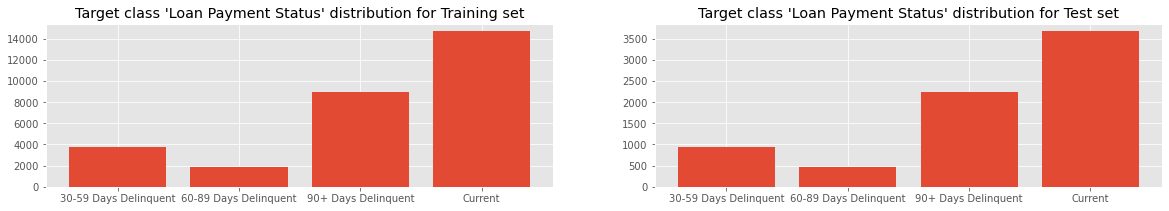

In [ ]:
# After train test split, look at the target class distribution
fig, ax = plt.subplots(1, 2, figsize = (20, 3))

plt.subplot(1, 2, 1)
y_train, y_test = sorted(y_train), sorted(y_test) # Just to see the distribution in same order
xs = [rev_dec_key[x] for x in Counter(y_train).keys()]
ys = Counter(y_train).values()
plt.bar(xs, ys);
plt.title(f"Target class 'Loan Payment Status' distribution for Training set");

plt.subplot(1, 2, 2)
xs = [rev_dec_key[x] for x in Counter(y_test).keys()]
ys = Counter(y_test).values()
plt.bar(xs, ys);
plt.title(f"Target class 'Loan Payment Status' distribution for Test set");

Let us preprocess our dataset for the final time now into one big single dataframe after having reduced our data modelling size and requirements.

In [ ]:
print(numerical_columns)

['Year Built', 'Physical Occupancy %', 'Loan Age', 'Property Acquisition Total Unit Count', 'Note Rate', 'Original UPB', 'Underwritten DSCR', 'Loan Payment Status', 'Number of Properties at Acquisition', 'UPB - Current', 'Loan Active Property Count', 'Loan Acquisition LTV', 'Original I_O Term', 'Original Interest Rate', 'Amortization Term', 'Original Term', 'Loan Acquisition UPB']


In [ ]:
tr_categorical_data = {}
tr_numerical_data = {}

ts_categorical_data = {}
ts_numerical_data = {}

tr_date_data = {}
ts_date_data = {}

for f in all_text_files:
    # Process the date column files
    if f.stem in date_columns:
        # Read the file contents into a list
        contents = [x.replace("\n", "") for x in open(f, "r").readlines()]
        
        # Determine the median date
        for idx in train_indices:
            element = contents[idx]
            non_missing_elements = []
            if element != "":
                if f.stem != "Prepayment Provision End Date":
                    dt = datetime.strptime(element, "%Y-%m-%d")
                else:
                    try:
                        element = re.findall(r"YM\((\d{2}/\d{2}/\d{4})\)", element)[0]
                        dt = datetime.strptime(element, "%m/%d/%Y")
                    except Exception as e:
                        pass
                non_missing_elements.append(dt)
        
        # Find the median date
        med = pd.Series(non_missing_elements).astype('datetime64[ns]').quantile(0.5, interpolation="midpoint")
        
        train_contents = []
        test_contents = []
        
        # Train Indices
        for idx in train_indices:
            element = contents[idx]
            if element != "":
                if f.stem != "Prepayment Provision End Date":
                    dt = datetime.strptime(element, "%Y-%m-%d")
                    train_contents.append([dt.year, dt.month, dt.day])
                else:
                    try:
                        element = re.findall(r"YM\((\d{2}/\d{2}/\d{4})\)", element)[0]
                        dt = datetime.strptime(element, "%m/%d/%Y")
                        train_contents.append([dt.year, dt.month, dt.day])
                    except Exception as e:
                        train_contents.append([med.year, med.month, med.day])
            else:
                train_contents.append([med.year, med.month, med.day])
        
        # Test Indices
        for idx in test_indices:
            element = contents[idx]
            if element != "":
                # Only the column of Prepayment Provision End Date has slashes instead of dashes, 
                # hence it needs to be handled separately, also it has multiple dates but we're 
                # Considering only the first date embedded in brackets 
                if f.stem != "Prepayment Provision End Date":
                    dt = datetime.strptime(element, "%Y-%m-%d")
                    test_contents.append([dt.year, dt.month, dt.day])
                else:
                    try:
                        element = re.findall(r"YM\((\d{2}/\d{2}/\d{4})\)", element)[0]
                        dt = datetime.strptime(element, "%m/%d/%Y")
                        test_contents.append([dt.year, dt.month, dt.day])
                    except Exception as e:
                        test_contents.append([med.year, med.month, med.day])
            else:
                test_contents.append([med.year, med.month, med.day])
        
        train_contents = np.array(train_contents)
        ss = StandardScaler()
        ss.fit(train_contents)
        
        # Even after all the above considerations, some data turns out to be nan
        # To avoid that and facilitate smooth training, perform imputation
        train_contents = pd.DataFrame(ss.transform(train_contents), columns = [f"{f.stem}_year", f"{f.stem}_month", f"{f.stem}_day"])
        test_contents = pd.DataFrame(ss.transform(test_contents), columns = [f"{f.stem}_year", f"{f.stem}_month", f"{f.stem}_day"])
        
        tr_date_data[f.stem] = train_contents.fillna(train_contents.mean())
        ts_date_data[f.stem] = test_contents.fillna(test_contents.mean())
    
    # Process the categorical columns
    elif (f.stem in categorical_columns) or (f.stem == target_column):
        # Read the file contents into a list
        contents = [x.replace("\n", "") for x in open(f, "r").readlines()]

        # Compute the counts
        count_contents = [x for x in contents if x != ""]
        most_common_value = Counter(contents).most_common()[0][0]

        # Fill null values with the most frequently occuring entry
        imputed_contents = []
        for element in contents:
            if element == "":
                imputed_contents.append(most_common_value)
            else:
                imputed_contents.append(element)

        # Do a train test split using the indices created above
        # And subsequently one-hot encode the data since this is categorical in nature
        train_contents = np.array([imputed_contents[x] for x in train_indices]).reshape(-1, 1)
        test_contents = np.array([imputed_contents[x] for x in test_indices]).reshape(-1, 1)
        
        enc = OneHotEncoder(handle_unknown='ignore')#, prefix = f.stem)
        enc.fit(train_contents)
        colnames = [f"{f.stem}_{x}" for x in enc.categories_[0]]
        
        tr_cat_data = pd.DataFrame(enc.transform(train_contents).toarray(), columns = colnames)
        ts_cat_data = pd.DataFrame(enc.transform(test_contents).toarray(), columns = colnames)
        tr_categorical_data[f.stem] = tr_cat_data
        ts_categorical_data[f.stem] = ts_cat_data
        
    # Process the numerical columns
    elif (f.stem in numerical_columns):
        contents = [x.replace("\n", "").replace("$", "").replace(",","") for x in open(f, "r").readlines()]
        
        # Compute median based on non-missing data in the train dataset 
        # And fill it in place of the missing data for all numerical columns
        # In the `Year Built` Column, we mostly have years but in some cases this field is set to
        # `Multiple Properties` which is a string, hence that particular value is considered as missing
        # data and we have performed median imputation to fill in that value
        non_missing_data = []
        for idx in train_indices:
            element = contents[idx]
            if element != "":
                if f.stem == "Year Built":
                    if element != "Multiple Properties":
                        non_missing_data.append(float(element))
                else:
                    non_missing_data.append(float(element))
        md_val = np.median(non_missing_data)
        
        train_contents, test_contents = [], []
        for idx in train_indices:
            element = contents[idx]
            if (element == "") or ((f.stem == "Year Built") and element == "Multiple Properties"):
                train_contents.append(md_val)            
            else:
                train_contents.append(float(element))

        for idx in test_indices:
            element = contents[idx]
            if (element == "") or ((f.stem == "Year Built") and element == "Multiple Properties"):
                test_contents.append(md_val)            
            else:
                test_contents.append(float(element))
            
        train_contents = np.array(train_contents).reshape(-1, 1)
        test_contents = np.array(test_contents).reshape(-1, 1)

        ss = StandardScaler()
        ss.fit(train_contents)
        train_contents = ss.transform(train_contents)
        test_contents = ss.transform(test_contents)
        
        tr_numerical_data[f.stem] = train_contents
        ts_numerical_data[f.stem] = test_contents 

In [ ]:
# Get the target variables
y_train = tr_categorical_data.pop(target_column)
y_test = ts_categorical_data.pop(target_column)

In [ ]:
# Collect all the test dataframes in one single list
test_data = []
for k, v in ts_categorical_data.items(): test_data.append(v)
for k, v in ts_date_data.items(): test_data.append(v)
for k, v in ts_numerical_data.items(): test_data.append(pd.DataFrame(v, columns = [k]))

In [ ]:
# Collect all train dataframes in one single list
train_data = []
for k, v in tr_categorical_data.items(): train_data.append(v)
for k, v in tr_date_data.items(): train_data.append(v)
for k, v in tr_numerical_data.items(): train_data.append(pd.DataFrame(v, columns = [k]))

# Build a regular DL Model

In [ ]:
# Import all the necessary Deep Learning Libraries
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Dense, Flatten, BatchNormalization, 
                                     Reshape, Concatenate, Dropout, Input, add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.callbacks import Callback

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, inputs, outputs, batch_size=32, shuffle=True):
        # Initialize with all the inputs, outputs and other things needed in computation
        # Of iterative batch generation
        self.inputs = inputs
        self.outputs = outputs
        self.batch_size = batch_size
        self.list_IDs = list(range(len(outputs)))
        self.n_classes = len(set(outputs.values.argmax(axis = -1).tolist()))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate batch of data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        # Shuffle the indices if shuffle = True at the end of every epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Subset into the datframes and create one batch of data
        # Combine all the inputs from all the datframes together in one single array
        
        ips = []
        for df in self.inputs:
            recs = df.iloc[list_IDs_temp, :].values.astype(np.float32)
            ips.append(recs)
        X = np.hstack(ips)
        
        y = self.outputs.iloc[list_IDs_temp].values
        
        return X, y

In [ ]:
# Define train and test generators
BATCH_SIZE = 48
train_gen = DataGenerator(train_data, y_train, BATCH_SIZE)
test_gen = DataGenerator(test_data, y_test, BATCH_SIZE, shuffle = False)

In [ ]:
# Have a look at the number of features and shapes of target and input
# Input dimensionality is that high due to our one-hot encoding across a lot 
# of categorical variables (17), some of which have a lot of levels in them 
temp_gen = DataGenerator(train_data, y_train, BATCH_SIZE)
sample = next(iter(temp_gen))
sample[0].shape, sample[1].shape

((48, 8703), (48, 4))

In [ ]:
# Build a sequential keras model
model = tf.keras.Sequential([
                            Input(sample[0].shape[-1],),
                            Dense(256, activation='relu'),
                            BatchNormalization(),
                            Dropout(0.3),
                            Dense(128, activation = 'relu'),
                            BatchNormalization(),
                            Dropout(0.1),
                            Dense(4, activation = 'softmax')
                            ])

In [ ]:
# Look at the parameters of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2228224   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
# Compile the model with a decently high learning rate and cross-entropy loss function
# Since we are performing classification here
lr = 5e-2
model.compile(
              optimizer=Adam(learning_rate = lr),
              loss="categorical_crossentropy"
)

In [ ]:
# Create a custom logger to only compute metrics pertaining to what is needed in model fitting
class validation_callback(Callback):
    def on_epoch_end(self, epoch, logs={}):

        # Test Dataset Predicitons
        preds = model.predict_generator(test_gen).argmax(axis = -1)
        trues = test_gen.outputs.values.argmax(axis = -1)
        test_f1s = f1_score(preds, trues, average = "macro")
        test_acc = accuracy_score(preds, trues)
        
        print(f"Epoch: {str(epoch):<2} Validation Accuracy: {test_acc*100:.3f}% | Validation F1 Score: {test_f1s*100:.3f}%")

In [ ]:
EPOCHS = 30
model.fit_generator(generator = train_gen, 
                    validation_data = test_gen,
                    use_multiprocessing = True, 
                    epochs = EPOCHS, 
                    verbose = 0,
                    callbacks=[validation_callback()])

Epoch: 0  Validation Accuracy: 88.934% | Validation F1 Score: 66.695%
Epoch: 1  Validation Accuracy: 87.871% | Validation F1 Score: 66.691%
Epoch: 2  Validation Accuracy: 89.302% | Validation F1 Score: 70.608%
Epoch: 3  Validation Accuracy: 89.125% | Validation F1 Score: 67.593%
Epoch: 4  Validation Accuracy: 88.498% | Validation F1 Score: 68.584%
Epoch: 5  Validation Accuracy: 85.200% | Validation F1 Score: 65.889%
Epoch: 6  Validation Accuracy: 88.539% | Validation F1 Score: 75.120%
Epoch: 7  Validation Accuracy: 89.384% | Validation F1 Score: 73.112%
Epoch: 8  Validation Accuracy: 85.882% | Validation F1 Score: 75.737%
Epoch: 9  Validation Accuracy: 87.653% | Validation F1 Score: 76.564%
Epoch: 10 Validation Accuracy: 89.193% | Validation F1 Score: 71.452%
Epoch: 11 Validation Accuracy: 89.343% | Validation F1 Score: 71.103%
Epoch: 12 Validation Accuracy: 88.662% | Validation F1 Score: 68.413%
Epoch: 13 Validation Accuracy: 88.089% | Validation F1 Score: 67.611%
Epoch: 14 Validation

<keras.callbacks.History>

In [ ]:
# Predict on test data and look at the other classification metrics

# Create containers to hold true and predicted values
# From the generator
dl_predictions = []; dl_trues = []

for index, (chunk_X, chunk_y) in enumerate(test_gen):
    trues = chunk_y.argmax(axis = -1)
    preds = model.predict(chunk_X, verbose = 0).argmax(axis = -1)
    dl_predictions.extend(preds.tolist())
    dl_trues.extend(trues.tolist())
    

# Show the classification report for the predictions
from sklearn.metrics import classification_report
trues = [rev_dec_key[x] for x in dl_trues]
preds = [rev_dec_key[x] for x in dl_predictions]

print(classification_report(trues, preds))

                       precision    recall  f1-score   support

30-59 Days Delinquent       0.86      0.85      0.85       943
60-89 Days Delinquent       0.33      0.48      0.39       476
  90+ Days Delinquent       0.88      0.80      0.84      2250
              Current       0.96      0.96      0.96      3669

             accuracy                           0.87      7338
            macro avg       0.76      0.77      0.76      7338
         weighted avg       0.88      0.87      0.87      7338



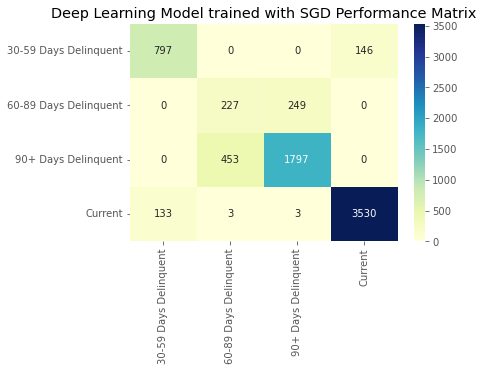

In [ ]:
import matplotlib as mpl
sns.heatmap(confusion_matrix(trues, preds), 
            norm = mpl.colors.Normalize(),
            cmap = "YlGnBu",
            xticklabels = sorted(list(set(trues))),
            yticklabels = sorted(list(set(trues))),
            annot = True, fmt = "d"
            )
plt.title(f"Deep Learning Model trained with SGD Performance Matrix");

The metrics for `Current` class and also for some delinquent classes are decent. However for `60-89 Days Delinquent` class, it is poor. This could be attributed to the fact that the support/count of this particular segment in the training data is very low.

# Build a Normal Machine Learning Model (Logistic Regression with SGD Classifier)

Logistic Regression is basically a Deep Neural Network with one output of sigmoid (Or a bunch of one vs rest sigmoid outputs). Also it can therefore be fit in a minibatch fashion using Gradient Descent, hence we would be using this method in order to account for the high dimensionality and high cardinality of our dataset.

In [ ]:
BATCH_SIZE = 64

clf = SGDClassifier(alpha = .0001, loss = 'log', penalty = 'l2', 
                    n_jobs = -1, shuffle=True, max_iter = 50, 
                    verbose = 0, tol = 0.001)
 
TOTAL_ROUNDS = 10
TRAIN_BATCHES = len(y_train) // BATCH_SIZE + 1
TEST_BATCHES = len(y_test) // BATCH_SIZE

# Rounds is similar to Epochs in Deep Neural Networks
for ep in range(TOTAL_ROUNDS):
    train_gen = DataGenerator(train_data, y_train, BATCH_SIZE)
    test_gen = DataGenerator(test_data, y_test, BATCH_SIZE, shuffle = False) 
    
    # Fit on the whole train data
    for index, (chunk_X, chunk_y) in enumerate(train_gen):
        chunk_y = chunk_y.argmax(axis = -1)
        clf.partial_fit(chunk_X, chunk_y, classes = [0, 1, 2, 3])
        if index >= 10: break
    
    # Evaluate on validation data    
    equals = 0; totals = 0
    predictions = []
    for index, (chunk_X, chunk_y) in enumerate(test_gen):
        trues = chunk_y.argmax(axis = -1)
        preds = clf.predict(chunk_X)
        predictions.extend(preds.tolist())
        equals += (trues == preds).sum()
        totals += len(trues)
        if index >= TEST_BATCHES: break
    test_acc = equals / totals
    
    print(f"Logistic Regression trained with SGD for {str(ep + 1):<2} Epoch/s | Test Accuracy: {test_acc * 100:.2f}%")

Logistic Regression trained with SGD for 1  Epoch/s | Test Accuracy: 81.32%
Logistic Regression trained with SGD for 2  Epoch/s | Test Accuracy: 81.14%
Logistic Regression trained with SGD for 3  Epoch/s | Test Accuracy: 86.69%
Logistic Regression trained with SGD for 4  Epoch/s | Test Accuracy: 79.27%
Logistic Regression trained with SGD for 5  Epoch/s | Test Accuracy: 85.00%
Logistic Regression trained with SGD for 6  Epoch/s | Test Accuracy: 81.04%
Logistic Regression trained with SGD for 7  Epoch/s | Test Accuracy: 87.33%
Logistic Regression trained with SGD for 8  Epoch/s | Test Accuracy: 84.76%
Logistic Regression trained with SGD for 9  Epoch/s | Test Accuracy: 85.53%
Logistic Regression trained with SGD for 10 Epoch/s | Test Accuracy: 84.74%


In [ ]:
trues = [rev_dec_key[x] for x in y_test.values.argmax(axis = -1)]
preds = [rev_dec_key[x] for x in predictions]

print(classification_report(trues, preds))

                       precision    recall  f1-score   support

30-59 Days Delinquent       0.78      0.64      0.71       943
60-89 Days Delinquent       0.28      0.16      0.20       476
  90+ Days Delinquent       0.83      0.91      0.87      2250
              Current       0.91      0.95      0.93      3669

             accuracy                           0.85      7338
            macro avg       0.70      0.67      0.68      7338
         weighted avg       0.83      0.85      0.84      7338



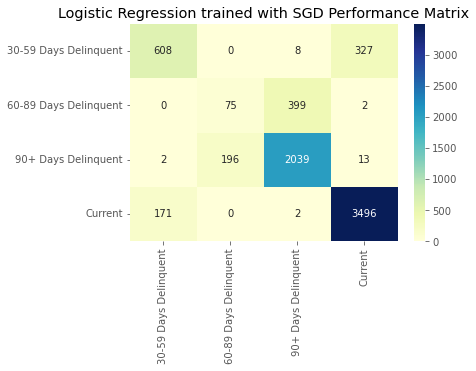

In [ ]:
import matplotlib as mpl
sns.heatmap(confusion_matrix(trues, preds), 
            norm = mpl.colors.Normalize(),
            cmap = "YlGnBu",
            xticklabels = sorted(list(set(trues))),
            yticklabels = sorted(list(set(trues))),
            annot = True, fmt = "d"
            )
plt.title(f"Logistic Regression trained with SGD Performance Matrix");

Similar performance as the deep learning model is observed here. It could be seen that the performance for less frequent class was better in the Deep Learning case than in this particular case.

# Probabilistic Deep Learning Model Case

We have built `Probabilistic Deep Learning` model using Google Colab using the above code. Attaching snippets of the trained model code below. 

The data preprocessing and generation code is same, hence attaching code of model training and evaluation below. The model seems to have been underfitting for the trained number of epochs, however for more epochs the hardware on Google Colab was giving memory issues and hence we couldn't train any further than this.

<img src="https://i.imgur.com/w1ike6A.png">


<img src="https://i.imgur.com/VRZiAdl.png">


<img src="https://i.imgur.com/2VUfX5C.png">


<img src="https://i.imgur.com/J9aOJCP.png">

# Conclusion

We tried three different modes of Machine Learning methods for the problem at hand to predict Loan Payment Status. The result of traditional Deep Learning model seemed to give the best accuracy for now (although we couldn't train PGMs to the full extent owing to resource constraints).

# References

1. [Keras API](https://keras.io/api/)
2. [Probabilistic Deep Learning lecture from ODSC](https://www.youtube.com/watch?v=X6pCO0-HYVE)
3. pgmpywebinar4 notebook
4. [Logistic Regresison with SGD](https://jpinjpblog.wordpress.com/2019/04/16/using-sklearns-sgdclassifier-with-partial_fit-and-generators-gridsearchcv/)